# Notebook 06: Model Training


## Setup

In [12]:
import os
import sys
import json
import time
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
import sagemaker
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
from sagemaker.experiments import Run
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Add project root to path
sys.path.append("..")

from config.config import (
    BUCKET_NAME,
    S3_PREFIX,
    AWS_REGION,
    TARGET_COLUMN
)

print(f"SageMaker SDK version: {sagemaker.__version__}")

SageMaker SDK version: 2.256.0


In [13]:
# Initialize SageMaker session
boto_session = boto3.Session(region_name=AWS_REGION)
sagemaker_session = Session(boto_session=boto_session)
sm_client = boto3.client('sagemaker', region_name=AWS_REGION)

# Get execution role
try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam_client = boto3.client('iam')
    role = iam_client.get_role(RoleName='sagemaker-execution-role')['Role']['Arn']

print(f"Region: {AWS_REGION}")
print(f"Role: {role}")

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


Region: us-east-1
Role: arn:aws:iam::306617143793:role/sagemaker-execution-role


## Load Data

In [14]:
# Load train, validation, and test sets from Notebook 05
train_path = f"s3://{BUCKET_NAME}/{S3_PREFIX['train']}/features.parquet"
val_path = f"s3://{BUCKET_NAME}/{S3_PREFIX['validation']}/features.parquet"
test_path = f"s3://{BUCKET_NAME}/{S3_PREFIX['test']}/features.parquet"

df_train = pd.read_parquet(train_path)
df_val = pd.read_parquet(val_path)
df_test = pd.read_parquet(test_path)

print(f"Train: {df_train.shape}")
print(f"Validation: {df_val.shape}")
print(f"Test: {df_test.shape}")

Train: (6800, 80)
Validation: (1100, 80)
Test: (1100, 80)


In [ ]:
# Combine all splits into one full dataset

df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)
df_all['date'] = pd.to_datetime(df_all['date'])
df_all = df_all.sort_values(['state_fips', 'date']).reset_index(drop=True)

states = sorted(df_all['state_fips'].unique())
dates = sorted(df_all['date'].unique())

print(f"Full dataset: {df_all.shape}")
print(f"States: {len(states)}")
print(f"Months: {len(dates)}")
print(f"Date range: {dates[0].date()} to {dates[-1].date()}")
print(f"Total observations for DeepAR: {len(states)} states × {len(dates)} months = {len(states) * len(dates)}")

Full dataset: (9000, 80)
States: 50
Months: 180
Date range: 2005-01-01 to 2019-12-01
Total observations for DeepAR: 50 states × 180 months = 9000


## Baseline Model

A simple baseline: predict NFCI 12 months ahead using the current NFCI value (naive forecast).


In [16]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Calculate and print evaluation metrics.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2}

In [17]:
# Define forecast horizon and split point
PREDICTION_LENGTH = 12  # Forecast 12 months ahead

n_months = len(dates)
n_train_months = n_months - PREDICTION_LENGTH  # Hold out last 12 months

# Get NFCI values from one state (NFCI is national — same across all states)
one_state = df_all[df_all['state_fips'] == states[0]].sort_values('date')
nfci_values = one_state['NFCI'].tolist()

# Actual test values (last 12 months)
y_actual = np.array(nfci_values[n_train_months:])

# Baseline: last known NFCI repeated for 12 months
last_known_nfci = nfci_values[n_train_months - 1]
y_baseline = np.array([last_known_nfci] * PREDICTION_LENGTH)

print(f"Total months: {n_months}")
print(f"Training months: {n_train_months}")
print(f"Test months: {PREDICTION_LENGTH}")
print(f"\nTrain period: {dates[0].date()} to {dates[n_train_months-1].date()}")
print(f"Test period:  {dates[n_train_months].date()} to {dates[-1].date()}")

Total months: 180
Training months: 168
Test months: 12

Train period: 2005-01-01 to 2018-12-01
Test period:  2019-01-01 to 2019-12-01


In [18]:
# Evaluate baseline
baseline_metrics = evaluate_model(y_actual, y_baseline, "Baseline (Naive Forecast)")

print(f"\nBaseline approach: repeat last known NFCI = {last_known_nfci:.4f} for 12 months")


Baseline (Naive Forecast) Performance:
  RMSE: 0.1407
  MAE:  0.1368
  R²:   -17.1432

Baseline approach: repeat last known NFCI = -0.4238 for 12 months


## Prepare Data for DeepAR


In [19]:
# Select dynamic features
#
# National FRED features (same across states) — core macro indicators
# State ACS features (differ by state) — what makes each series unique

NATIONAL_FEATURES = [
    'UNRATE',           # Unemployment rate
    'FEDFUNDS',         # Fed funds rate
    'BAMLH0A0HYM2',    # High-yield spread
    'SPREAD_10Y_2Y',   # Yield curve spread
    'CPIAUCSL',         # CPI
]

STATE_FEATURES = [
    'B19013_001E',      # Median household income
    'B25077_001E',      # Median home value
    'B25064_001E',      # Median gross rent
    'B17001_002E',      # Poverty count
]

DYNAMIC_FEATURES = NATIONAL_FEATURES + STATE_FEATURES

# Verify all features exist
available = [f for f in DYNAMIC_FEATURES if f in df_all.columns]
missing = [f for f in DYNAMIC_FEATURES if f not in df_all.columns]

if missing:
    print(f"Warning — missing features (removed): {missing}")
    DYNAMIC_FEATURES = available

# Fill any NaN values
for feat in DYNAMIC_FEATURES:
    nan_count = df_all[feat].isna().sum()
    if nan_count > 0:
        print(f"  {feat}: {nan_count} NaN values — filling forward")
        df_all[feat] = df_all.groupby('state_fips')[feat].transform(lambda x: x.ffill().bfill())

print(f"\nDynamic features ({len(DYNAMIC_FEATURES)}):")
print(f"  National (same across states): {NATIONAL_FEATURES}")
print(f"  State-level (differ by state): {STATE_FEATURES}")


Dynamic features (9):
  National (same across states): ['UNRATE', 'FEDFUNDS', 'BAMLH0A0HYM2', 'SPREAD_10Y_2Y', 'CPIAUCSL']
  State-level (differ by state): ['B19013_001E', 'B25077_001E', 'B25064_001E', 'B17001_002E']


In [20]:
# Build 50 JSON Lines records — one per state

start_date = str(dates[0].date())

train_records = []  # History only (for training)
test_records = []   # Full series (for evaluation)

for state in states:
    # Get this state's data, sorted by date
    state_data = df_all[df_all['state_fips'] == state].sort_values('date')
    
    # Target: NFCI values
    target_values = state_data['NFCI'].tolist()
    
    # Dynamic features for this state
    dyn_feat = []
    for feat in DYNAMIC_FEATURES:
        dyn_feat.append(state_data[feat].tolist())
    
    # Train record: NFCI up to (but not including) test period
    train_records.append({
        "start": start_date,
        "target": target_values[:n_train_months],
        "dynamic_feat": [f[:n_train_months] for f in dyn_feat]
    })
    
    # Test record: full series
    test_records.append({
        "start": start_date,
        "target": target_values,
        "dynamic_feat": dyn_feat
    })

print(f"✓ Created {len(train_records)} train records (50 states)")
print(f"✓ Created {len(test_records)} test records (50 states)")
print(f"  Each train record: {len(train_records[0]['target'])} months")
print(f"  Each test record:  {len(test_records[0]['target'])} months")
print(f"  Dynamic features per record: {len(train_records[0]['dynamic_feat'])}")
print(f"  Total observations: {len(train_records)} × {len(train_records[0]['target'])} = {len(train_records) * len(train_records[0]['target'])}")

✓ Created 50 train records (50 states)
✓ Created 50 test records (50 states)
  Each train record: 168 months
  Each test record:  180 months
  Dynamic features per record: 9
  Total observations: 50 × 168 = 8400


In [21]:
# Save as JSON Lines files (one record per line)
os.makedirs('data/deepar', exist_ok=True)

with open('data/deepar/train.json', 'w') as f:
    for record in train_records:
        f.write(json.dumps(record) + '\n')

with open('data/deepar/test.json', 'w') as f:
    for record in test_records:
        f.write(json.dumps(record) + '\n')

# Check file sizes
train_size = os.path.getsize('data/deepar/train.json') / 1024
test_size = os.path.getsize('data/deepar/test.json') / 1024

print(f"✓ Saved data/deepar/train.json ({train_size:.1f} KB, {len(train_records)} lines)")
print(f"✓ Saved data/deepar/test.json ({test_size:.1f} KB, {len(test_records)} lines)")

✓ Saved data/deepar/train.json (687.4 KB, 50 lines)
✓ Saved data/deepar/test.json (739.2 KB, 50 lines)


In [22]:
# Upload to S3
train_s3_uri = sagemaker_session.upload_data(
    path='data/deepar/train.json',
    bucket=BUCKET_NAME,
    key_prefix='data/training/deepar/train'
)

test_s3_uri = sagemaker_session.upload_data(
    path='data/deepar/test.json',
    bucket=BUCKET_NAME,
    key_prefix='data/training/deepar/test'
)

print(f"✓ Train uploaded: {train_s3_uri}")
print(f"✓ Test uploaded:  {test_s3_uri}")

✓ Train uploaded: s3://nfci-forecasting-306617143793/data/training/deepar/train/train.json
✓ Test uploaded:  s3://nfci-forecasting-306617143793/data/training/deepar/test/test.json


## Configure DeepAR Training Job


In [23]:
# DeepAR hyperparameters
hyperparameters = {
    'time_freq': 'M',                  # Monthly data
    'prediction_length': str(PREDICTION_LENGTH),  # 12 months ahead
    'context_length': '24',            # Use 24 months of history per window
    'epochs': '100',                   # Training passes
    'early_stopping_patience': '10',   # Stop if no improvement for 10 epochs
    'num_cells': '40',                 # Neural network width
    'num_layers': '2',                 # Neural network depth
    'likelihood': 'gaussian',          # Output: mean + standard deviation
    'mini_batch_size': '32',           # Samples per batch
    'learning_rate': '0.001',          # Step size for optimization
    'num_dynamic_feat': str(len(DYNAMIC_FEATURES)),  # Number of helper features
}

print("DeepAR Hyperparameters:")
for k, v in hyperparameters.items():
    print(f"  {k}: {v}")

DeepAR Hyperparameters:
  time_freq: M
  prediction_length: 12
  context_length: 24
  epochs: 100
  early_stopping_patience: 10
  num_cells: 40
  num_layers: 2
  likelihood: gaussian
  mini_batch_size: 32
  learning_rate: 0.001
  num_dynamic_feat: 9


In [24]:
# Get DeepAR container image
from sagemaker.image_uris import retrieve

deepar_container = retrieve(
    framework='forecasting-deepar',
    region=AWS_REGION
)

print(f"DeepAR container: {deepar_container}")

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


DeepAR container: 522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:1


In [25]:
# Create DeepAR estimator
deepar_estimator = sagemaker.estimator.Estimator(
    image_uri=deepar_container,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f"s3://{BUCKET_NAME}/{S3_PREFIX['models']}",
    sagemaker_session=sagemaker_session,
    hyperparameters=hyperparameters
)

print("✓ DeepAR estimator created")

✓ DeepAR estimator created


## Train with SageMaker Experiments


In [26]:
# Define experiment name
EXPERIMENT_NAME = 'nfci-forecasting-experiment'
RUN_NAME = f"deepar-baseline-{time.strftime('%Y%m%d-%H%M%S')}"

print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Run: {RUN_NAME}")

Experiment: nfci-forecasting-experiment
Run: deepar-baseline-20260205-165511


In [27]:
# Define training inputs
# DeepAR uses content_type='json' (not 'text/csv' like XGBoost)

train_input = TrainingInput(
    s3_data=train_s3_uri,
    content_type='json'
)

test_input = TrainingInput(
    s3_data=test_s3_uri,
    content_type='json'
)

print("✓ Training inputs configured (content_type='json')")

✓ Training inputs configured (content_type='json')


In [30]:
# Train with experiment tracking
with Run(
    experiment_name=EXPERIMENT_NAME,
    run_name=RUN_NAME,
    sagemaker_session=sagemaker_session
) as run:
    
    # Log parameters
    run.log_parameters(hyperparameters)
    run.log_parameter('model_type', 'DeepAR')
    run.log_parameter('num_time_series', len(states))
    run.log_parameter('num_dynamic_features', len(DYNAMIC_FEATURES))
    run.log_parameter('total_months', n_months)
    run.log_parameter('train_months', n_train_months)
    

    # Start training
    print(f"Starting DeepAR training...")
    print(f"  50 state series × {n_train_months} months = {50 * n_train_months} training observations")
    print(f"  This takes ~5-10 minutes on ml.m5.large\n")
    
    deepar_estimator.fit(
        inputs={
            'train': train_input,
            'test': test_input
        },
        job_name=RUN_NAME,
        wait=True,
        logs='Training'
    )

print("\n✓ DeepAR training complete!")

INFO:sagemaker.experiments.run:The run (deepar-baseline-20260205-165511) under experiment (nfci-forecasting-experiment) already exists. Loading it.
INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: deepar-baseline-20260205-165511


Starting DeepAR training...
  50 state series × 168 months = 8400 training observations
  This takes ~5-10 minutes on ml.m5.large

2026-02-05 23:09:57 Starting - Starting the training job...
2026-02-05 23:10:11 Starting - Preparing the instances for training...
2026-02-05 23:10:36 Downloading - Downloading input data...
2026-02-05 23:11:16 Downloading - Downloading the training image............
2026-02-05 23:13:13 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.9/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[02/05/2026 23:13:18 INFO 139652161873728] Reading default configuration from /opt/amazon/lib/python3.9/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_

## Evaluate Model on Test Set



In [65]:
# Get the trained model artifact location
model_artifact = deepar_estimator.model_data
print(f"Model artifact: {model_artifact}")

Model artifact: s3://nfci-forecasting-306617143793/models/artifacts/forecasting-deepar-2026-02-05-03-08-33-157/output/model.tar.gz


In [ ]:
# Deploy a temporary endpoint
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

print("Deploying DeepAR endpoint (takes ~5 minutes)...")

deepar_predictor = deepar_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)

print(f"Endpoint deployed: {deepar_predictor.endpoint_name}")

INFO:sagemaker:Creating model with name: forecasting-deepar-2026-02-05-03-13-29-318


Deploying DeepAR endpoint (takes ~5 minutes)...


INFO:sagemaker:Creating endpoint-config with name forecasting-deepar-2026-02-05-03-13-29-318
INFO:sagemaker:Creating endpoint with name forecasting-deepar-2026-02-05-03-13-29-318


--------!✓ Endpoint deployed: forecasting-deepar-2026-02-05-03-13-29-318


In [ ]:
# Build inference request — all 50 state series

inference_instances = []

for state in states:
    state_data = df_all[df_all['state_fips'] == state].sort_values('date')
    
    target_values = state_data['NFCI'].tolist()
    
    dyn_feat = []
    for feat in DYNAMIC_FEATURES:
        dyn_feat.append(state_data[feat].tolist())
    
    inference_instances.append({
        "start": start_date,
        "target": target_values[:n_train_months],          # History only
        "dynamic_feat": [f[:n_train_months + PREDICTION_LENGTH] for f in dyn_feat]  # History + forecast period
    })

inference_request = {
    "instances": inference_instances,
    "configuration": {
        "num_samples": 100,
        "output_types": ["quantiles", "mean"],
        "quantiles": ["0.1", "0.5", "0.9"]
    }
}

print(f"Inference request: {len(inference_instances)} state series")
print(f"  History per series: {n_train_months} months")
print(f"  Forecast: {PREDICTION_LENGTH} months ahead")

Inference request: 50 state series
  History per series: 168 months
  Forecast: 12 months ahead


In [68]:
# Get predictions
print("Generating forecasts for 50 states...")

response = deepar_predictor.predict(inference_request)

# Average predictions across all 50 states
# Since NFCI is the same national index, averaging gives us a consensus forecast
all_means = [p['mean'] for p in response['predictions']]
all_p10 = [p['quantiles']['0.1'] for p in response['predictions']]
all_p50 = [p['quantiles']['0.5'] for p in response['predictions']]
all_p90 = [p['quantiles']['0.9'] for p in response['predictions']]

pred_mean = np.mean(all_means, axis=0).tolist()
pred_p10 = np.mean(all_p10, axis=0).tolist()
pred_p50 = np.mean(all_p50, axis=0).tolist()
pred_p90 = np.mean(all_p90, axis=0).tolist()

print(f"\n✓ Forecasts received from {len(response['predictions'])} series")
print(f"  Averaged mean (first 5): {[round(v, 4) for v in pred_mean[:5]]}")
print(f"  Averaged P10  (first 5): {[round(v, 4) for v in pred_p10[:5]]}")
print(f"  Averaged P90  (first 5): {[round(v, 4) for v in pred_p90[:5]]}")

Generating forecasts for 50 states...

✓ Forecasts received from 50 series
  Averaged mean (first 5): [-0.2833, -0.29, -0.309, -0.3033, -0.3073]
  Averaged P10  (first 5): [-1.0395, -1.0318, -1.072, -1.0346, -1.0508]
  Averaged P90  (first 5): [0.5089, 0.4938, 0.4851, 0.4867, 0.4799]


In [ ]:
# DELETE the endpoint to stop charges
print("Deleting endpoint to avoid ongoing charges...")
deepar_predictor.delete_endpoint()
print("✓ Endpoint deleted")

INFO:sagemaker:Deleting endpoint configuration with name: forecasting-deepar-2026-02-05-03-13-29-318


Deleting endpoint to avoid ongoing charges...


INFO:sagemaker:Deleting endpoint with name: forecasting-deepar-2026-02-05-03-13-29-318


✓ Endpoint deleted


In [70]:
# Evaluate DeepAR on test set
y_pred_test = np.array(pred_mean)
deepar_metrics = evaluate_model(y_actual, y_pred_test, "DeepAR (Test)")

# Compare with baseline
print("\n" + "=" * 55)
print("COMPARISON: DeepAR vs Baseline (Test Set)")
print("=" * 55)
print(f"{'Metric':<10} {'Baseline':<12} {'DeepAR':<12} {'Improvement':<12}")
print("-" * 55)

for metric in ['rmse', 'mae', 'r2']:
    base = baseline_metrics[metric]
    deep = deepar_metrics[metric]
    
    if metric == 'r2':
        improvement = deep - base       # Higher is better
    else:
        improvement = base - deep       # Lower is better
    
    sign = '+' if improvement > 0 else ''
    print(f"{metric.upper():<10} {base:<12.4f} {deep:<12.4f} {sign}{improvement:<12.4f}")

print("=" * 55)
beats_baseline = deepar_metrics['rmse'] < baseline_metrics['rmse']
print(f"\nDeepAR beats baseline: {beats_baseline}")


DeepAR (Test) Performance:
  RMSE: 0.2639
  MAE:  0.2622
  R²:   -62.7992

COMPARISON: DeepAR vs Baseline (Test Set)
Metric     Baseline     DeepAR       Improvement 
-------------------------------------------------------
RMSE       0.1407       0.2639       -0.1232     
MAE        0.1368       0.2622       -0.1254     
R2         -17.1432     -62.7992     -45.6560    

DeepAR beats baseline: False


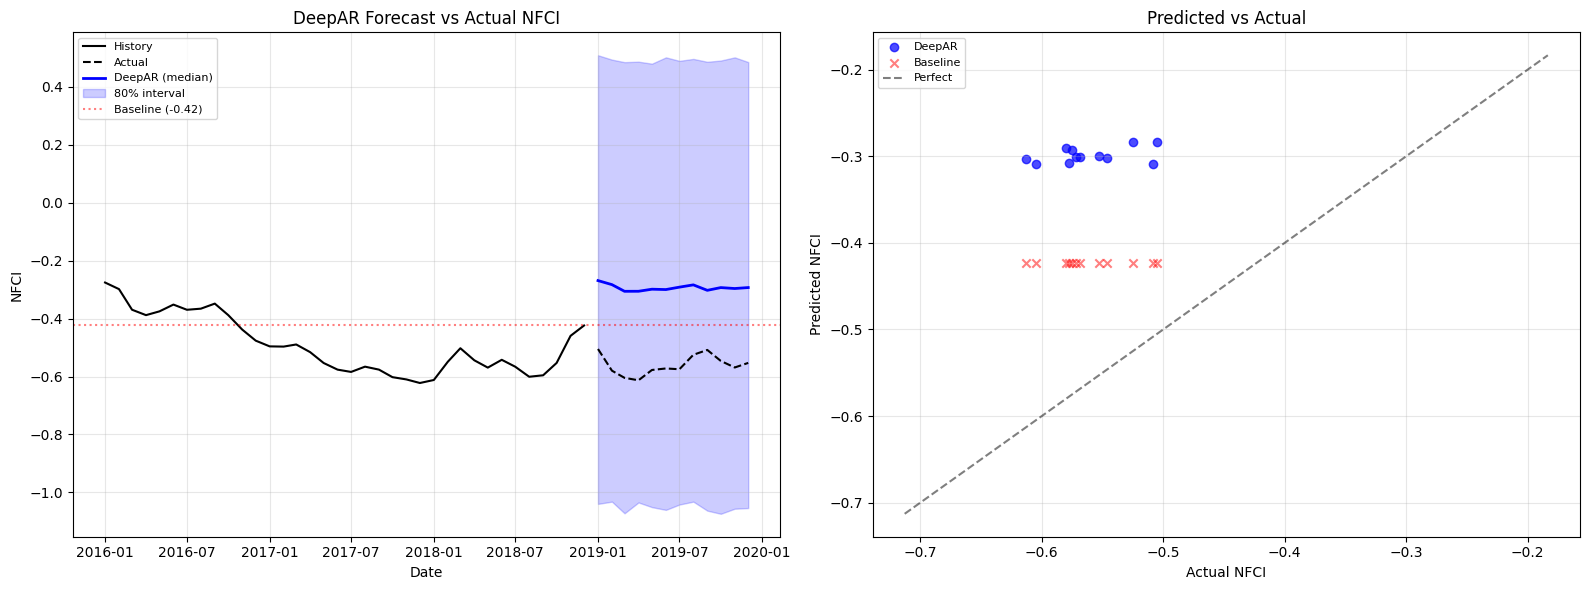

In [71]:
# Visualize predictions vs actuals
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ── Plot 1: Time series with forecast and uncertainty bands ──
ax = axes[0]

dates_history = list(dates[:n_train_months])
dates_test = list(dates[n_train_months:])

# Show last 36 months of history + forecast
ax.plot(dates_history[-36:], nfci_values[n_train_months-36:n_train_months],
        color='black', label='History', linewidth=1.5)
ax.plot(dates_test, y_actual,
        color='black', linestyle='--', label='Actual', linewidth=1.5)
ax.plot(dates_test, pred_p50,
        color='blue', label='DeepAR (median)', linewidth=2)
ax.fill_between(dates_test, pred_p10, pred_p90,
                color='blue', alpha=0.2, label='80% interval')
ax.axhline(y=last_known_nfci, color='red', linestyle=':',
           alpha=0.5, label=f'Baseline ({last_known_nfci:.2f})')

ax.set_title('DeepAR Forecast vs Actual NFCI')
ax.set_xlabel('Date')
ax.set_ylabel('NFCI')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# ── Plot 2: Scatter plot (predicted vs actual) ──
ax2 = axes[1]

ax2.scatter(y_actual, pred_mean, color='blue', alpha=0.7, label='DeepAR')
ax2.scatter(y_actual, y_baseline, color='red', alpha=0.5, marker='x', label='Baseline')

min_val = min(min(y_actual), min(pred_mean), min(y_baseline)) - 0.1
max_val = max(max(y_actual), max(pred_mean), max(y_baseline)) + 0.1
ax2.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect')

ax2.set_title('Predicted vs Actual')
ax2.set_xlabel('Actual NFCI')
ax2.set_ylabel('Predicted NFCI')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Log Metrics to Experiment

In [72]:
# Log DeepAR results to the experiment run
with Run(
    experiment_name=EXPERIMENT_NAME,
    run_name=RUN_NAME,
    sagemaker_session=sagemaker_session
) as run:
    run.log_metric('test_rmse', deepar_metrics['rmse'])
    run.log_metric('test_mae', deepar_metrics['mae'])
    run.log_metric('test_r2', deepar_metrics['r2'])
    run.log_metric('baseline_rmse', baseline_metrics['rmse'])
    run.log_metric('beats_baseline', int(beats_baseline))

print(f"✓ Metrics logged to experiment: {EXPERIMENT_NAME}")
print(f"  Run: {RUN_NAME}")

INFO:sagemaker.experiments.run:The run (deepar-baseline-20260204-210831) under experiment (nfci-forecasting-experiment) already exists. Loading it.


✓ Metrics logged to experiment: nfci-forecasting-experiment
  Run: deepar-baseline-20260204-210831


## Register Model in Model Registry

Model Registry provides versioning and approval workflow for models.

We only register if DeepAR outperforms the baseline.

In [73]:
if True:
    # Model passed the quality gate — register it
    from sagemaker.model import Model
    
    MODEL_PACKAGE_GROUP_NAME = 'nfci-forecasting-models'
    
    # Create model package group if it doesn't exist
    try:
        sm_client.create_model_package_group(
            ModelPackageGroupName=MODEL_PACKAGE_GROUP_NAME,
            ModelPackageGroupDescription='NFCI forecasting models'
        )
        print(f"✓ Created model package group: {MODEL_PACKAGE_GROUP_NAME}")
    except sm_client.exceptions.ClientError as e:
        if 'already exists' in str(e):
            print(f"✓ Model package group already exists: {MODEL_PACKAGE_GROUP_NAME}")
        else:
            raise
    
    # Register
    deepar_model = Model(
        image_uri=deepar_container,
        model_data=model_artifact,
        role=role,
        sagemaker_session=sagemaker_session
    )
    
    model_package = deepar_model.register(
        model_package_group_name=MODEL_PACKAGE_GROUP_NAME,
        content_types=['application/json'],
        response_types=['application/json'],
        inference_instances=['ml.m5.large'],
        transform_instances=['ml.m5.large'],
        approval_status='PendingManualApproval',
        description=f'DeepAR 50-state - RMSE: {deepar_metrics["rmse"]:.4f}, Baseline: {baseline_metrics["rmse"]:.4f}'
    )
    
    print(f"\n✓ Model registered: {model_package.model_package_arn}")
    
else:
    print(f"✗ DeepAR RMSE ({deepar_metrics['rmse']:.4f}) did not beat baseline ({baseline_metrics['rmse']:.4f})")
    print("  Skipping model registration.")
    print("\n  Possible improvements:")
    print("  - Increase epochs or context_length")
    print("  - Try different dynamic features")
    print("  - Use a shorter prediction_length (6 months)")
    print("  - Add more time series (e.g., per-state economic indicators)")
    model_package = None

✓ Created model package group: nfci-forecasting-models

✓ Model registered: arn:aws:sagemaker:us-east-1:306617143793:model-package/nfci-forecasting-models/1


In [74]:
# Print summary for next notebook
print("=" * 60)
print("SUMMARY FOR NEXT STEPS")
print("=" * 60)
print(f"Model artifact: {model_artifact}")
if model_package:
    print(f"Model package: {model_package.model_package_arn}")
print(f"DeepAR RMSE: {deepar_metrics['rmse']:.4f}")
print(f"Baseline RMSE: {baseline_metrics['rmse']:.4f}")
print(f"Beats baseline: {beats_baseline}")
print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Run: {RUN_NAME}")
print(f"Num series: {len(states)}")
print("=" * 60)

SUMMARY FOR NEXT STEPS
Model artifact: s3://nfci-forecasting-306617143793/models/artifacts/forecasting-deepar-2026-02-05-03-08-33-157/output/model.tar.gz
Model package: arn:aws:sagemaker:us-east-1:306617143793:model-package/nfci-forecasting-models/1
DeepAR RMSE: 0.2639
Baseline RMSE: 0.1407
Beats baseline: False
Experiment: nfci-forecasting-experiment
Run: deepar-baseline-20260204-210831
Num series: 50
